In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    RocCurveDisplay,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay,
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
import warnings
from google.colab import drive
drive.mount('/content/drive')

warnings.filterwarnings("ignore")
np.random.seed(42)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# === 1. Load data ===
df=pd.read_excel('/content/drive/MyDrive/a_Dataset_CreditScoring.xlsx')

In [3]:
# === 2. Identify target ===
# Adjust if your target column is named differently
target_col = "TARGET"
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found. Please set correct target.")

X = df.drop(columns=[target_col])
y = df[target_col]

In [4]:
# === 3. Optional: Handle / incorporate location if exists ===
# Example: if there's a column 'Region' or 'State', you can keep it as categorical.
# If you want geographic priors or external regional default rates, merge here.
location_col = "Region"  # uncomment & adjust if present
if location_col in X.columns:
     # Example: you might want to group infrequent categories
     freq = X[location_col].value_counts(normalize=True)
     rare = freq[freq < 0.01].index
     X[location_col] = X[location_col].replace(rare, "Other")


In [6]:
# === 4. Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42
)


In [7]:
# === 5. Feature type separation ===
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# Remove any ID-like column if present
for col in ["ID", "Id", "id", "CustID"]:
    if col in numeric_features:
        numeric_features.remove(col)
    if col in categorical_features:
        categorical_features.remove(col)


In [8]:
# === 6. Preprocessing pipelines ===
numeric_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

preprocessor = ColumnTransformer(
    [
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
)


In [9]:
# === 7. Define candidate models with imbalance handling ===
# We'll use SMOTE to oversample the minority class in the training pipeline
logistic_pipe = ImbPipeline(
    [
        ("pre", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("clf", LogisticRegression(max_iter=2000)),
    ]
)

rf_pipe = ImbPipeline(
    [
        ("pre", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("clf", RandomForestClassifier(random_state=42)),
    ]
)


In [10]:
# === 8. Hyperparameter search spaces ===
logistic_param_dist = {
    "clf__C": np.logspace(-4, 4, 30),
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs"],
    # class_weight is handled via SMOTE so not here; you could also try without SMOTE and class_weight
}

rf_param_dist = {
    "clf__n_estimators": [100, 200, 400],
    "clf__max_depth": [None, 5, 10, 20],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__bootstrap": [True, False],
}


In [11]:
# === 9. Cross-validated tuning ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

log_search = RandomizedSearchCV(
    logistic_pipe,
    logistic_param_dist,
    n_iter=20,
    scoring="roc_auc",
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42,
)

rf_search = RandomizedSearchCV(
    rf_pipe,
    rf_param_dist,
    n_iter=30,
    scoring="roc_auc",
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42,
)


In [12]:
# === 10. Fit ===
print("Tuning Logistic Regression...")
log_search.fit(X_train, y_train)
print(f"Best logistic params: {log_search.best_params_}")
print(f"Best logistic CV AUC: {log_search.best_score_:.4f}")

print("\nTuning Random Forest...")
rf_search.fit(X_train, y_train)
print(f"Best RF params: {rf_search.best_params_}")
print(f"Best RF CV AUC: {rf_search.best_score_:.4f}")


Tuning Logistic Regression...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best logistic params: {'clf__solver': 'lbfgs', 'clf__penalty': 'l2', 'clf__C': np.float64(0.002395026619987486)}
Best logistic CV AUC: 0.7923

Tuning Random Forest...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best RF params: {'clf__n_estimators': 200, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 4, 'clf__max_depth': 10, 'clf__bootstrap': True}
Best RF CV AUC: 0.7786



=== Evaluation: Logistic Regression ===
ROC AUC: 0.7633
Classification report:
              precision    recall  f1-score   support

           0       0.92      0.76      0.83       625
           1       0.36      0.67      0.47       125

    accuracy                           0.75       750
   macro avg       0.64      0.72      0.65       750
weighted avg       0.83      0.75      0.77       750




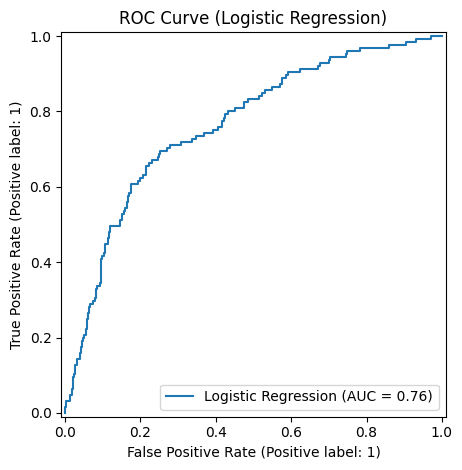

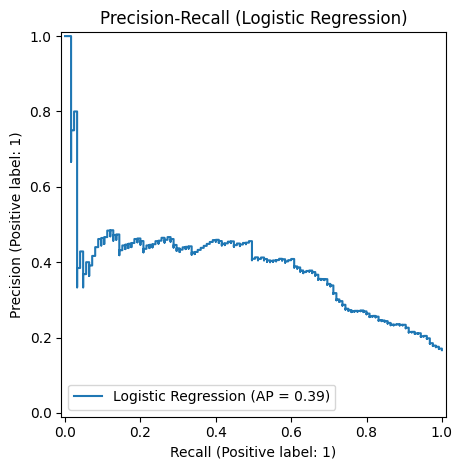

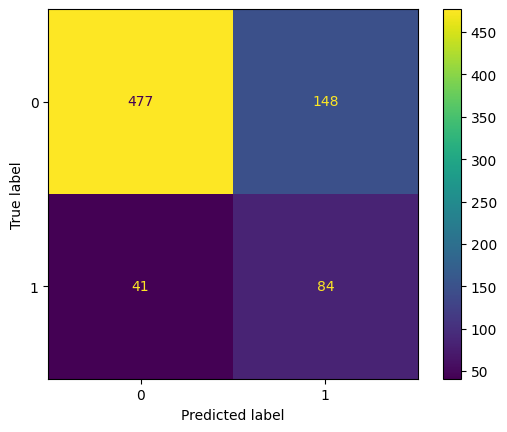

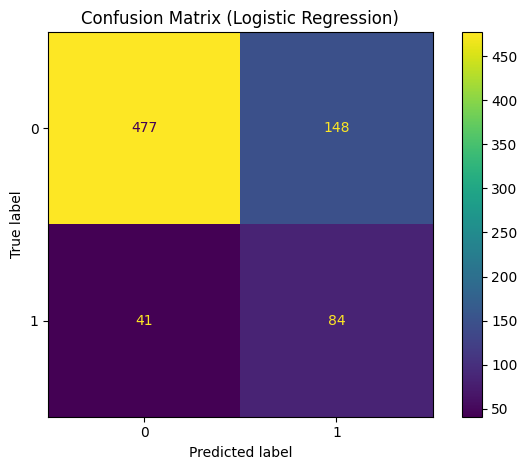



=== Evaluation: Random Forest ===
ROC AUC: 0.7697
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       625
           1       0.43      0.37      0.40       125

    accuracy                           0.81       750
   macro avg       0.66      0.64      0.64       750
weighted avg       0.80      0.81      0.81       750




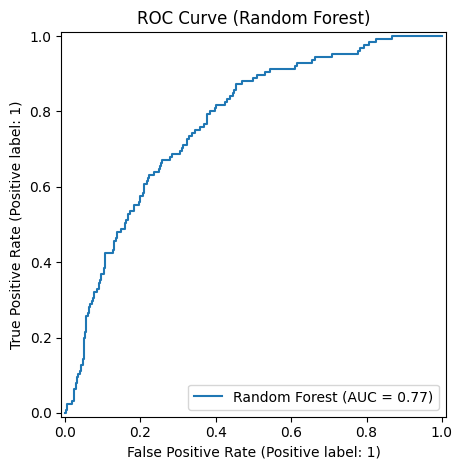

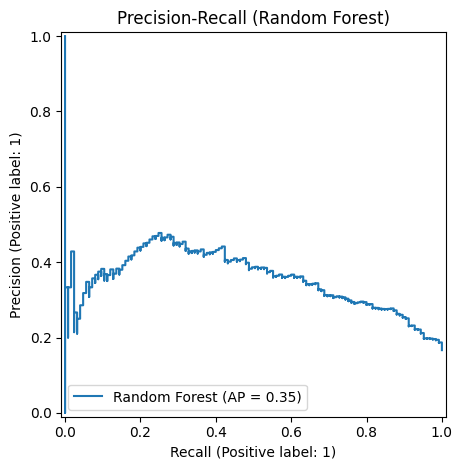

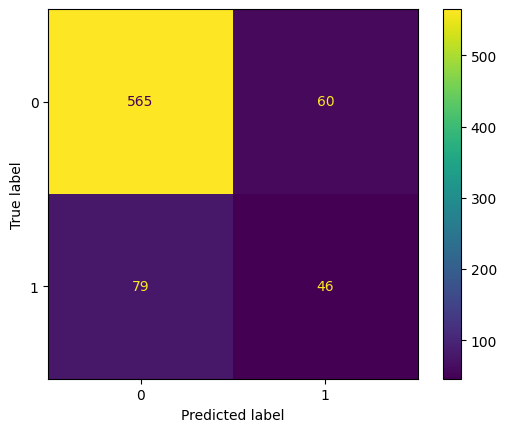

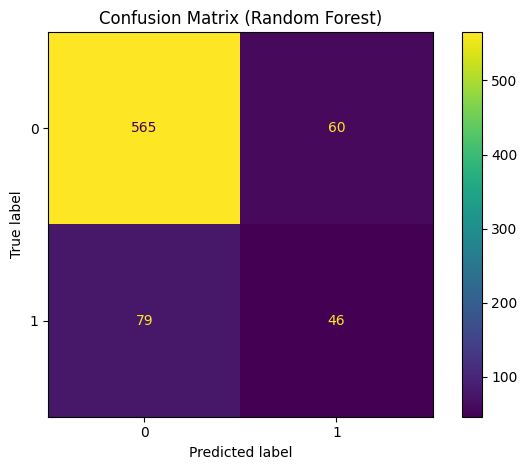

In [14]:
# === 11. Evaluation on holdout ===
def evaluate(model, X_eval, y_eval, name):
    y_proba = model.predict_proba(X_eval)[:, 1]
    y_pred = model.predict(X_eval)
    auc = roc_auc_score(y_eval, y_proba)
    print(f"\n=== Evaluation: {name} ===")
    print(f"ROC AUC: {auc:.4f}")
    print("Classification report:")
    print(classification_report(y_eval, y_pred, zero_division=0))
    print()
    # ROC curve
    RocCurveDisplay.from_estimator(model, X_eval, y_eval, name=name)
    plt.title(f"ROC Curve ({name})")
    plt.tight_layout()
    plt.show()
    print()
    # Precision-Recall
    disp = PrecisionRecallDisplay.from_estimator(model, X_eval, y_eval, name=name)
    plt.title(f"Precision-Recall ({name})")
    plt.tight_layout()
    plt.show()
    print()
    # Confusion matrix
    ConfusionMatrixDisplay.from_estimator(model, X_eval, y_eval).plot()
    plt.title(f"Confusion Matrix ({name})")
    plt.tight_layout()
    plt.show()
    print()

# Best models from search
best_log = log_search.best_estimator_
best_rf = rf_search.best_estimator_

evaluate(best_log, X_test, y_test, "Logistic Regression")
evaluate(best_rf, X_test, y_test, "Random Forest")



Top 30 feature importances (Random Forest):
TLDel60Cnt24       0.097319
TLDel3060Cnt24     0.084387
TLDel60Cnt         0.067989
InqFinanceCnt24    0.050534
TLDel60CntAll      0.049930
TLDel90Cnt24       0.049543
TLBadDerogCnt      0.046352
TL75UtilCnt        0.046296
TLBalHCPct         0.045849
TLSatPct           0.040712
InqCnt06           0.039936
CollectCnt         0.036803
TL50UtilCnt        0.034379
TLTimeFirst        0.030800
TLSum              0.027341
TLSatCnt           0.027120
TLTimeLast         0.026359
TLOpenPct          0.025702
InqTimeLast        0.022598
TLBadCnt24         0.021712
TLMaxSum           0.021618
TLOpen24Pct        0.020643
TLCnt24            0.020061
DerogCnt           0.018964
TLCnt              0.018290
TLCnt12            0.016159
TLCnt03            0.009399
BanruptcyInd       0.003207
dtype: float64


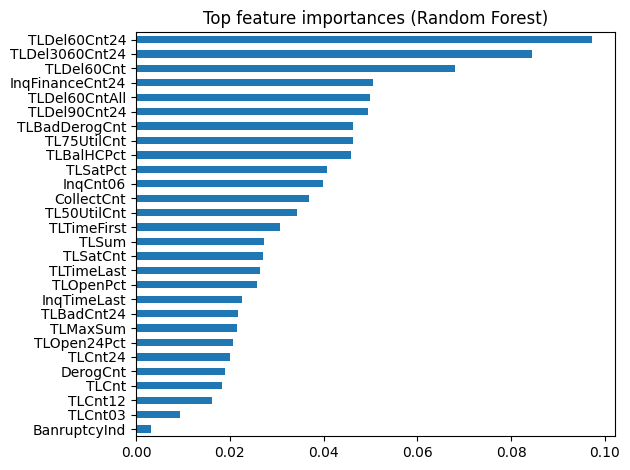

In [15]:
# === 12. Feature importance (Random Forest) ===
# Need to unwrap the preprocessing to get feature names
def get_feature_names(preprocessor):
    num_names = numeric_features
    cat_names = []
    if categorical_features:
        ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
        cat_encoded = ohe.get_feature_names_out(categorical_features)
        cat_names = list(cat_encoded)
    return num_names + cat_names

# Extract RF feature importances
rf_pre = best_rf.named_steps["pre"]
rf_clf = best_rf.named_steps["clf"]
feature_names = get_feature_names(rf_pre)
importances = rf_clf.feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(30)
print("\nTop 30 feature importances (Random Forest):")
print(feat_imp)

# Plot
plt.figure()
feat_imp.plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top feature importances (Random Forest)")
plt.tight_layout()
plt.show()




Computing SHAP for Random Forest (approximate, subsample)...


 98%|===================| 392/400 [00:21<00:00]       

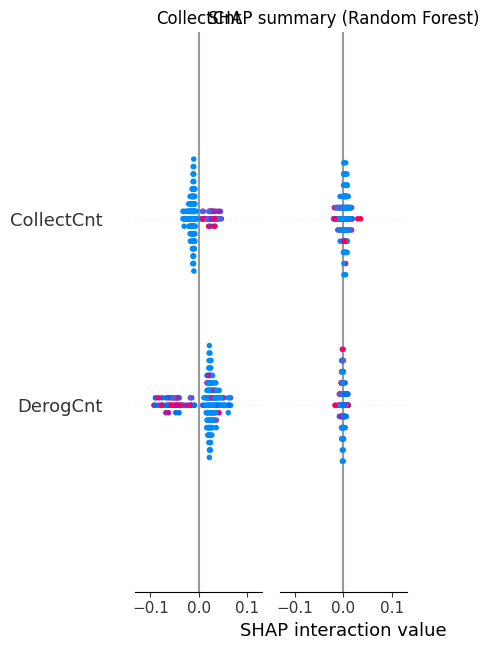

In [16]:
# === 13. SHAP explanations (on a subsample for speed) ===
print("\nComputing SHAP for Random Forest (approximate, subsample)...")
# Build a pipeline that outputs transformed features for SHAP
X_shap = X_test.sample(n=min(200, X_test.shape[0]), random_state=42)
y_shap = y_test.loc[X_shap.index]

# Use shap.TreeExplainer directly on the RF with preprocessed data
# Need a function to get transformed matrix
X_train_transformed = rf_pre.transform(X_train)
X_shap_transformed = rf_pre.transform(X_shap)

explainer = shap.Explainer(rf_clf, X_train_transformed, feature_names=feature_names)
shap_values = explainer(X_shap_transformed)

# Summary plot
shap.summary_plot(shap_values, features=X_shap_transformed, feature_names=feature_names, show=False)
plt.title("SHAP summary (Random Forest)")
plt.tight_layout()
plt.show()


In [17]:
# === 14. Save best model pipeline ===
joblib.dump(best_rf, "best_credit_scoring_pipeline.joblib")
print("\nSaved best model pipeline to 'best_credit_scoring_pipeline.joblib'")



Saved best model pipeline to 'best_credit_scoring_pipeline.joblib'


In [19]:
# === 15. Example scoring function ===
def score_new(df_new):
    """
    df_new: raw DataFrame with same columns (except target).
    returns: probability of default
    """
    model = joblib.load("best_credit_scoring_pipeline.joblib")
    proba = model.predict_proba(df_new)[:, 1]
    return proba

# Usage example (uncomment when you have new data):
new_data = pd.DataFrame([X_test.iloc[0].to_dict()])
print("Predicted default probability:", score_new(new_data)[0])

Predicted default probability: 0.15536216853118587
